In [1]:

# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder


In [2]:
# 2. Load dataset
data = pd.read_csv("GaltonFamilies.csv")

In [3]:

# SIMPLE LINEAR REGRESSION

X_simple = data[["midparentHeight"]]
y = data["childHeight"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_simple, y, test_size=0.2, random_state=42)

# Train model
simple_model = LinearRegression()
simple_model.fit(X_train, y_train)

# Predict
y_pred_simple = simple_model.predict(X_test)

In [4]:
# Evaluate
print("Simple Linear Regression")
print("Coefficient:", simple_model.coef_)
print("Intercept:", simple_model.intercept_)
print("R²:", r2_score(y_test, y_pred_simple))
print("MSE:", mean_squared_error(y_test, y_pred_simple))

Simple Linear Regression
Coefficient: [0.64350916]
Intercept: 22.234182747470697
R²: 0.10875642912240857
MSE: 10.618985299573685


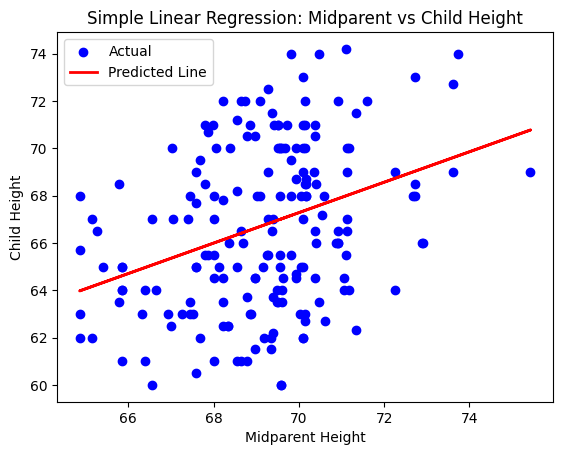

In [5]:
# Visualization
plt.scatter(X_test, y_test, color="blue", label="Actual")
plt.plot(X_test, y_pred_simple, color="red", linewidth=2, label="Predicted Line")
plt.xlabel("Midparent Height")
plt.ylabel("Child Height")
plt.title("Simple Linear Regression: Midparent vs Child Height")
plt.legend()
plt.show()

In [ ]:
# ======================================
# MULTIPLE LINEAR REGRESSION
# ======================================
# Encode categorical gender
data_encoded = data.copy()
le = LabelEncoder()
data_encoded["gender"] = le.fit_transform(data_encoded["gender"])  # male=1, female=0

# Use multiple features
X_multi = data_encoded[["father", "mother", "gender"]]
y_multi = data_encoded["childHeight"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42)

# Train model
multi_model = LinearRegression()
multi_model.fit(X_train, y_train)

# Predict
y_pred_multi = multi_model.predict(X_test)

# Evaluate
print("\nMultiple Linear Regression")
print("Coefficients:", multi_model.coef_)
print("Intercept:", multi_model.intercept_)
print("R²:", r2_score(y_test, y_pred_multi))
print("MSE:", mean_squared_error(y_test, y_pred_multi))

# Compare predicted vs actual
plt.scatter(y_test, y_pred_multi, color="green")
plt.xlabel("Actual Child Height")
plt.ylabel("Predicted Child Height")
plt.title("Multiple Linear Regression: Predicted vs Actual")
plt.show()

In [ ]:
# ===== Simple Linear Regression: SGD + animated line (stable) =====
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

# --- Data (Galton if present; else synthetic) ---
use_galton = ('data' in globals()
              and {'midparentHeight','childHeight'}.issubset(set(data.columns)))
if use_galton:
    X_s = data[['midparentHeight']].to_numpy().astype(float)
    y_s = data['childHeight'].to_numpy().astype(float).reshape(-1, 1)
else:
    np.random.seed(42)
    X_s = 2 * np.random.rand(300, 1)
    y_s = 4 + 3 * X_s + np.random.randn(300, 1)

# --- Standardize X only (keep y in original units) ---
x_scaler = StandardScaler()
Xz = x_scaler.fit_transform(X_s)

# --- SGD setup: smaller step + averaging for stability ---
sgd_s = SGDRegressor(
    loss="squared_error",
    penalty=None,
    alpha=0.0,
    learning_rate="constant",
    eta0=0.01,          # smaller step
    max_iter=1,
    tol=None,
    random_state=42,
    warm_start=True,
    average=True        # stabilizes SGD
)

epochs = 40
coef_hist_s, intercept_hist_s = [], []

rng = np.random.RandomState(42)
for epoch in range(epochs):
    idx = rng.permutation(len(Xz))
    sgd_s.partial_fit(Xz[idx], y_s[idx].ravel())

    # model is y = a * z + b, where z = (x - mu)/sigma
    a = float(sgd_s.coef_[0])
    b = float(sgd_s.intercept_[0])

    # convert to original units: y = (a/sigma)*x + (b - a*mu/sigma)
    slope = a / x_scaler.scale_[0]
    intercept = b - a * x_scaler.mean_[0] / x_scaler.scale_[0]

    coef_hist_s.append(slope)
    intercept_hist_s.append(intercept)

# --- Animate regression line evolution ---
x_line = np.linspace(X_s.min(), X_s.max(), 200).reshape(-1, 1)

fig, ax = plt.subplots()
ax.scatter(X_s, y_s, alpha=0.6)
line, = ax.plot([], [], color="red", linewidth=2, label="SGD line")

# final reference line (dashed green)
final_slope = coef_hist_s[-1]
final_intercept = intercept_hist_s[-1]
y_final = final_slope * x_line + final_intercept
ax.plot(x_line, y_final, color="green", lw=2, ls="--", label="Final line")

# keep axes tight to data + a bit of padding
ax.set_xlim(X_s.min(), X_s.max())
y_lo = min(y_s.min(), y_final.min()) - 1.0
y_hi = max(y_s.max(), y_final.max()) + 1.0
ax.set_ylim(y_lo, y_hi)
ax.legend()

def init():
    line.set_data([], [])
    return line,

def update(frame):
    slope = coef_hist_s[frame]
    intercept = intercept_hist_s[frame]
    y_line = slope * x_line + intercept
    line.set_data(x_line, y_line)
    ax.set_title(f"Simple Linear Regression — Epoch {frame+1}/{epochs}")
    return line,

ani = FuncAnimation(fig, update, frames=epochs, init_func=init, blit=False, interval=250)
HTML(ani.to_jshtml())
